## Part B Question 3

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from math import floor
from math import sqrt 
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [5]:
from keras import backend as K
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## From Question 1

In [6]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [7]:
category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

In [8]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

In [9]:
all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]

## From Question 2

In [10]:
def Q2_encode_categorical_feature(feature, name, dataset, is_string, num_categories, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    emb = layers.Embedding(input_dim=num_categories+1, output_dim=floor(num_categories//divisor))
    embedded = emb(encoded_feature)

    return layers.Flatten()(embedded)

In [11]:
def square_roots(l):
    result = [sqrt(i) for i in l]
    return result

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


#### Best hyperparamters value : 'learning_rate': 0.046185127256095915, 'divisor': 2, 'hidden_units': 8

In [13]:
learning_rate = 0.046185127256095915
divisor = 2
hidden_units = 8

## Question 3

In [14]:
# old test set
Q3_old_df = pd.read_csv('hdb_price_prediction_old.csv')

Q3_old_test_df = Q3_old_df[Q3_old_df["year"]>2020].copy()
Q3_old_test_df = Q3_old_test_df.drop(category_not_used, axis = 1)
Q3_old_test_ds = dataframe_to_dataset(Q3_old_test_df)
Q3_old_test_ds = Q3_old_test_ds.batch(128)

# new test set
Q3_new_test_2021_df = test_dataframe[test_dataframe["year"]==2021].copy()
Q3_new_test_2022_df = test_dataframe[test_dataframe["year"]==2022].copy()

Q3_new_test_2021_ds = dataframe_to_dataset(Q3_new_test_2021_df)
Q3_new_test_2022_ds = dataframe_to_dataset(Q3_new_test_2022_df)

Q3_new_test_2021_ds = Q3_new_test_2021_ds.batch(256)
Q3_new_test_2022_ds = Q3_new_test_2022_ds.batch(256)

## Question 3A

**Using 2E model from the best epoch for 3A according to the clarification on the discussion board**

In [15]:
Q2E_model = keras.models.load_model('PartB_best_model/', custom_objects={"r2":r2})
Q2E_model.load_weights('PartB_bestepoch/')

In [16]:
# old test set
Q3_old_df = pd.read_csv('hdb_price_prediction_old.csv')

Q3_old_test_df = Q3_old_df[Q3_old_df["year"]>2020].copy()
Q3_old_test_df = Q3_old_test_df.drop(category_not_used, axis = 1)
Q3_old_test_ds = dataframe_to_dataset(Q3_old_test_df)
Q3_old_test_ds = Q3_old_test_ds.batch(128)

# new test set
Q3_new_test_2021_df = test_dataframe[test_dataframe["year"]==2021].copy()
Q3_new_test_2022_df = test_dataframe[test_dataframe["year"]==2022].copy()

Q3_new_test_2021_ds = dataframe_to_dataset(Q3_new_test_2021_df)
Q3_new_test_2022_ds = dataframe_to_dataset(Q3_new_test_2022_df)

Q3_new_test_2021_ds = Q3_new_test_2021_ds.batch(256)
Q3_new_test_2022_ds = Q3_new_test_2022_ds.batch(256)


## Question 3A

In [17]:
old_test_loss, old_test_R2 = Q2E_model.evaluate(Q3_old_test_ds)
print('Old Test RMSE: %f' % sqrt(old_test_loss))
print('Old Test R^2: %f' % old_test_R2)

new_test_2021_loss, new_test_2021_R2 = Q2E_model.evaluate(Q3_new_test_2021_ds)
print('Test RMSE_2021: %f' % sqrt(new_test_2021_loss))
print('Test R^2_2021: %f' % (new_test_2021_R2))

new_test_2022_loss, new_test_2022_R2 = Q2E_model.evaluate(Q3_new_test_2022_ds)
print('Test RMSE_2022: %f' % sqrt(new_test_2022_loss))
print('Test R^2_2022: %f' % (new_test_2022_R2))

#Output in a table

data = {"Old Test RMSE": [sqrt(old_test_loss)],
        "Old Test R^2": [(old_test_R2)],
        "Test RMSE_2021": [sqrt(new_test_2021_loss)],
        "Test R^2_2021": [(new_test_2021_R2)],
        "Test RMSE_2022": [(new_test_2022_loss)],
        "Test R^2_2022": [(new_test_2022_R2)]}

data_df = pd.DataFrame.from_dict(data)
data_df

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


131/131 [==============================] - 1s 2ms/step - loss: 5597425152.0000 - r2: 0.7832
Old Test RMSE: 74815.941831
Old Test R^2: 0.783178
114/114 [==============================] - 0s 2ms/step - loss: 6625486336.0000 - r2: 0.7472
Test RMSE_2021: 81397.090464
Test R^2_2021: 0.747247
67/67 [==============================] - 0s 3ms/step - loss: 14154502144.0000 - r2: 0.5040
Test RMSE_2022: 118972.694951
Test R^2_2022: 0.504003


,Old Test RMSE,Old Test R^2,Test RMSE_2021,Test R^2_2021,Test RMSE_2022,Test R^2_2022
0,74815.941831,0.783178,81397.090464,0.747247,1.415450e+10,0.504003


## Question 3B 
#### Compare the extent to which model degradation has impacted your model to that of the team's linear regression model and explain why this has occured.

| Linear Regression Model |  R^2 value |            
| --- | --- |
| Q1B Test > 2020 | .627 |
| Q3B Old Test > 2020  | .760 |
| Q3B Test  == 2021  | .715 |
| Q3B Test  == 2022  | .464 |

--**Neural Network Model**--

| NN model |  R^2 value |
| --- | --- |
| Q3B Old Test > 2020  | .783178 |
| Q3B Test  == 2021  | .747247 |
| Q3B Test  == 2022  | .504003 |


**Model degradation has led to a more signiifcant drop in R^2 value in the linear regression model as compared to the neural network model. As the multi-layer neural network has the ability to capture non-linear relationships, even though there is a change in characteristics of the dataset, the neural network model still performs better.**

## Question 3C

#### Identifying Covariate shift 

In [18]:
# As we used train_ds for best_model, we are going to use train_dataframe

train_df_shift = train_dataframe.copy()
Q3_old_test_df_shift = Q3_old_test_df.copy()
test_df_2021_shift = Q3_new_test_2021_df.copy()
test_df_2022_shift = Q3_new_test_2022_df.copy()

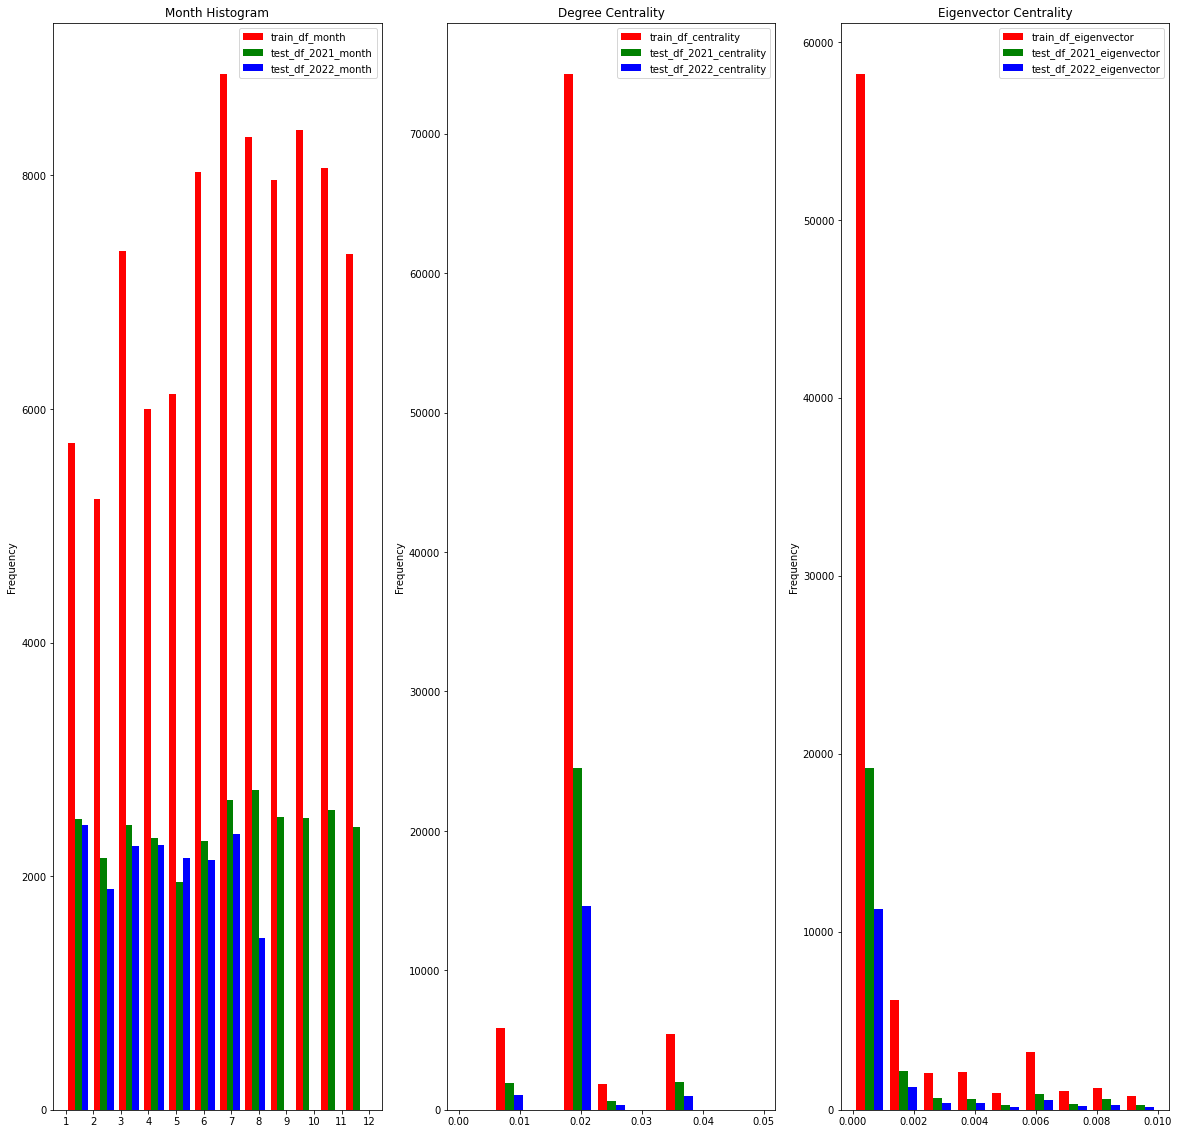

In [19]:
fig, axes =plt.subplots(1,3, figsize=(20,20))
axes[0].hist([train_df_shift["month"], test_df_2021_shift["month"],test_df_2022_shift["month"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_month', 'test_df_2021_month', 'test_df_2022_month'],rwidth=0.8)
axes[0].legend(loc='upper right')
axes[0].set_title('Month Histogram')
axes[0].set_xticks(range(1,13))
axes[0].set_ylabel('Frequency')

axes[1].hist([train_df_shift["degree_centrality"], test_df_2021_shift["degree_centrality"],test_df_2022_shift["degree_centrality"]],bins = np.linspace(0, 0.05, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_centrality', 'test_df_2021_centrality', 'test_df_2022_centrality'],rwidth=0.8)
axes[1].legend(loc='upper right')
axes[1].set_title('Degree Centrality')
axes[1].set_ylabel('Frequency')

axes[2].hist([train_df_shift["eigenvector_centrality"], test_df_2021_shift["eigenvector_centrality"],test_df_2022_shift["eigenvector_centrality"]],bins = np.linspace(0, 0.01, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_eigenvector', 'test_df_2021_eigenvector', 'test_df_2022_eigenvector'],rwidth=0.8)
axes[2].legend(loc='upper right')
axes[2].set_title('Eigenvector Centrality')
axes[2].set_ylabel('Frequency')

plt.show()

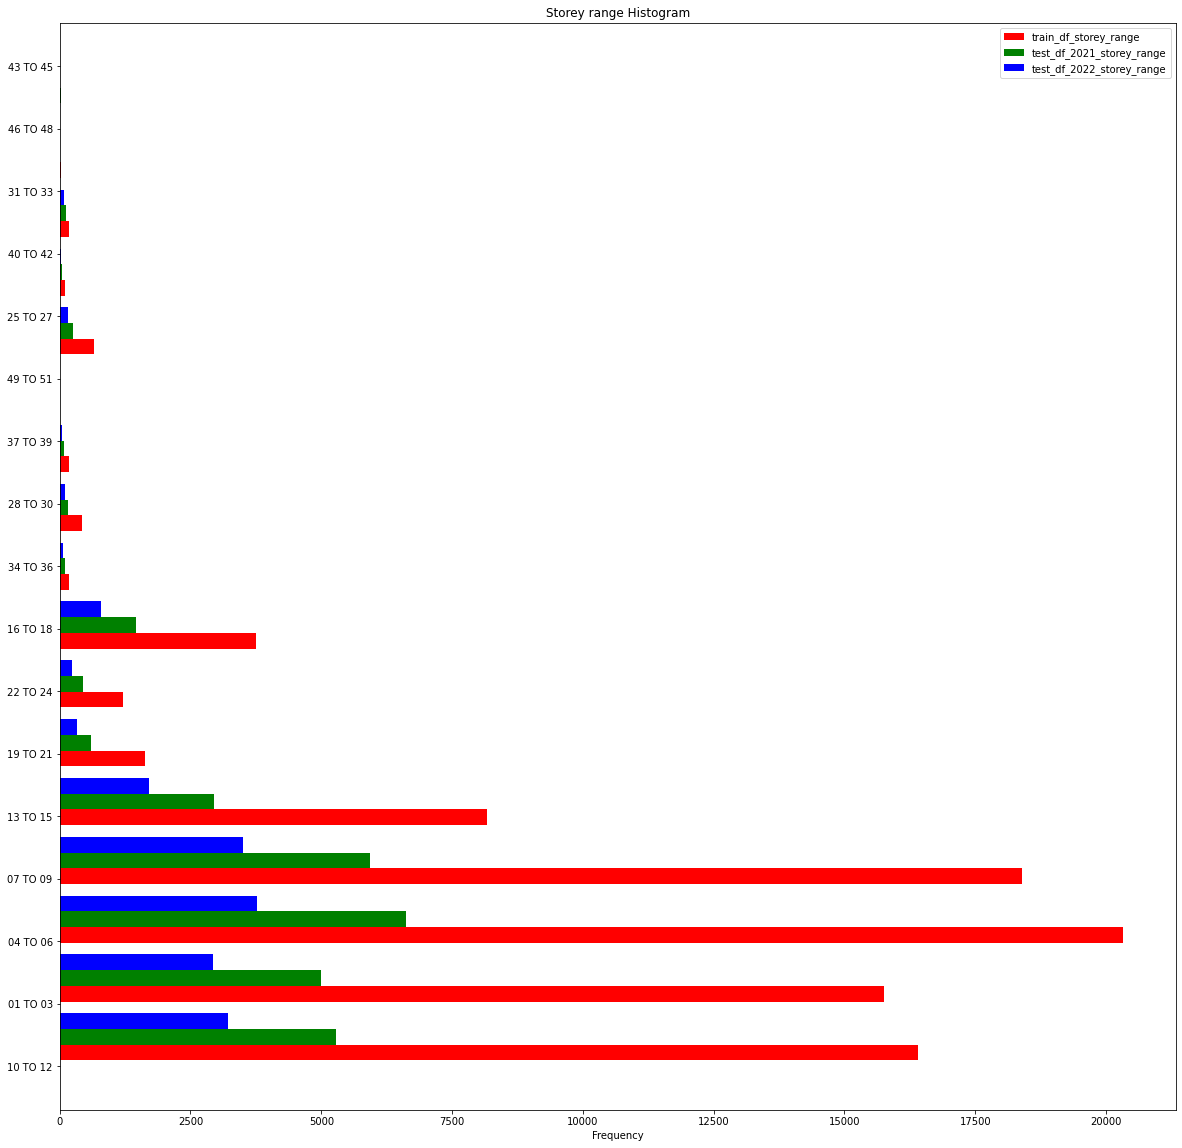

In [23]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["storey_range"], test_df_2021_shift["storey_range"],test_df_2022_shift["storey_range"]],bins = train_df_shift["storey_range"].nunique(), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_storey_range', 'test_df_2021_storey_range', 'test_df_2022_storey_range'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Storey range Histogram')
axes.set_xlabel('Frequency')
plt.show()

## Question 3C 

#### Which variable showed the largest covariate/label shift that might have led to the drop in model performance as seen in 3b? 

**From the histogram plot, the Month has the largest distribution shift within the train and test dataset which could be the reason for the drop in R^2 values**

**The easiest way would be to drop the features which are being classifed as drifiting, however this might result in a loss of information**. **Alternatively, it would be to retrieve more updated dataset and integrate into training.**

## Question 3D & 3E

#### RFE.py

In [26]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""
import keras_tuner
import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])

    # TODO: define the input layer here (your code from Q2)

    divisor = 2
    hidden_units = 8
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.046185127256095915)
    
    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",train_ds, True, storey_range_num_categories, divisor)
    
    #Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)
    
    all_features_input = [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
            
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    model_history = {}
    # Model trained using the best hyperparameters
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(all_features)
    output = layers.Dense(1, activation="linear")(hidden_layer)
    model = keras.Model(all_inputs, output)
    model.compile(optimizer=optimizer, loss= "mse",metrics=[r2])

    model_history["model"] = model.fit(train_ds, epochs=50, validation_data = test_ds, verbose=1, callbacks=callback)
    
    val_loss_hx = square_roots(model_history["model"].history["val_loss"]) # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)

vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_5/truediv:0', description="created by layer 'normalization_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_4/truediv:0', description="created by layer 'normalization_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, n

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 2s 4ms/step - loss: 84233969664.0000 - r2: -2.5428 - val_loss: 17914851328.0000 - val_r2: 0.3487
Epoch 2/50
342/342 [==============================] - 2s 4ms/step - loss: 9193890816.0000 - r2: 0.6115 - val_loss: 15100820480.0000 - val_r2: 0.4486
Epoch 3/50
342/342 [==============================] - 2s 4ms/step - loss: 7906354176.0000 - r2: 0.6649 - val_loss: 14291372032.0000 - val_r2: 0.4771
Epoch 4/50
342/342 [==============================] - 2s 4ms/step - loss: 7305051648.0000 - r2: 0.6904 - val_loss: 13262029824.0000 - val_r2: 0.5147
Epoch 5/50
342/342 [==============================] - 2s 4ms/step - loss: 6865902080.0000 - r2: 0.7088 - val_loss: 12781097984.0000 - val_r2: 0.5317
Epoch 6/50
342/342 [==============================] - 2s 4ms/step - loss: 6460293120.0000 - r2: 0.7258 - val_loss: 12580141056.0000 - val_r2: 0.5400
Epoch 7/50
342/342 [==============================] - 2s 4ms/step - loss: 6078106112.0000 - r2: 0.7424 - val_loss: 

In [27]:
best_feature_subset = []
input = [
                    "month",
                    "storey_range",
                    "flat_model_type",
                    "floor_area_sqm",
                    "remaining_lease_year",
                    "degree_centrality",
                    "eigenvector_centrality",
                    "dist_to_nearest_stn",
                    "dist_to_dhoby"
                    ]

for i in range(len(vec)):
    if vec[i] == 1:
        best_feature_subset.append(input[i])

print(best_feature_subset)
        

['storey_range', 'flat_model_type', 'floor_area_sqm', 'remaining_lease_year', 'dist_to_nearest_stn', 'dist_to_dhoby']


## Best features
**Best feature subset is  storey_range, flat_model_type, floor_area_sqm, remaining_lease_year, dist_to_nearest_stn and dist_to_dhoby**

#### Compare these features and discuss if there is any concept shift

**From the best feature subset on the new test set, it is similar to the best feature subset of the old test set. I do not think that there is a concept shift on the features("Month" and "Degree_centrality").**

**In fact, I believe it is due to the pandemic, rising inflation and interest rates, it has led to a change in consumers' behaviour. People are more prudent about buying high-value assets and such behaviour are not reflected sufficiently by the inputted features. Therefore, when the model runs its prediction on the recent datasets, it performs poorly.**

## CONCLUSION

#### Question 1
##### 1. Neural Networks vs Traditional machine learning models

**Neural network models are capabale of learning from unlabeled or unstructured data whereas traditional machine learning models generally learn to process structured data. In the machine learning pipeline. feature engineering comes right after data cleaning and visualization where the expertise of data scientists is required. However, in the neural network pipeline, there is no need for explict feature engineering in the deep learning pipepine. The neural network learns features from the data by itself and captures all non-linear relationships.**

**Neural networks provide flexibility in the structure of inputs and outputs which machine learning lacks. They are capabale of capturing spatial and temporal relationships between features.**

##### 2. Improvements to traditional machine learning models
**Feature selection and feature engineering would be the best bet to improve the accuracy of traditional machine learning models. Feature engineering helps to extracts more information from existing data and these features may allow the model to have a higher ability to explain the variance in training data.**

**Feature selection finds out the best subset of attributes which better explains the relationship of independent variables with target variable.**


#### Question 2

##### 1. Bayesian and Hyperband optimization

**Bayesian Optimization builds a probability model of the objective function and uses it to select hyperparameters to evaluate in the true objective function.**

**Hyperband is essentially just a grid search over the optimal allocation strategy. So at each individual trial the set of hyperparameters is chosen randomly. Hyperband is the extension of the Successive Halving algorithm.** 

**Random search tests hyperparameter sets at random, hence it runs the risk of missing the ideal set of hyperparameters and forgoing peak model performance. However, with Bayesian optimization method,the user do not have to incorporate randomness and risk missing the optimal solution. Although, Bayesian optimization does has its drawbacks as additional time is required to determine the next hyperparameters to evaluate based on the results of the previous iterations.**

##### 2. Random search vs Grid search

**Depending on the size of the hyperparameter search space and use case, the benefits of using grid search against random search varies.** 

**Using the brute force grid search method is simple and straightforward but an increase in the size of hyperparameter search space will result in an exponential rise in run time and computation.**

**Random search method would reduce the computation time significantly but user might run the risk of missing the optimal case.**




#### Question 3

**Concept shift may have been the lead cause of model degradation, due to the pandemic, rising tensions between superpowers and high inflation rate, the consumers' behaviours has changed significantly over the past few years.**

**Since the model is trained on past data, the model do not have the information on the current economical factors that have led to changes in housing prices.**